In [ ]:
# Imports
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
# Upload the data
from google.colab import files
uploaded = files.upload()

Saving 2016_predicted_sentiment.csv to 2016_predicted_sentiment (1).csv


In [ ]:
sentiment_df_2016 = pd.read_csv('2016_predicted_sentiment.csv', parse_dates=['date'])
sentiment_df_2016['net_sentiment'] = sentiment_df_2016['sentiment_score'] * sentiment_df_2016['sentiment']
sentiment_df_2016.head()

,date,text,label,sentiment_label,sentiment_score,sentiment,net_sentiment
0,2016-01-04,"General Motors, Gazing at Future, Invests $500...",NaN,POSITIVE,0.936707,1,0.936707
1,2016-01-04,G.M.’s Investment in Lyft Hedges Against a Fut...,NaN,POSITIVE,0.843959,1,0.843959
2,2016-01-05,Carmakers Set to Grab Spotlight at Internation...,NaN,POSITIVE,0.997886,1,0.997886
3,2016-01-06,"On Display at CES, Tech Ideas in Their Awkward...",NaN,NEGATIVE,0.998428,-1,-0.998428
4,2016-01-07,Carmakers Forge Ahead With Electric Vehicles ...,NaN,POSITIVE,0.996091,1,0.996091


In [ ]:
daily_sentiment = sentiment_df_2016.groupby('date')['net_sentiment'].sum().reset_index()
daily_sentiment.head()

,date,net_sentiment
0,2016-01-04,1.780666
1,2016-01-05,0.997886
2,2016-01-06,-0.998428
3,2016-01-07,0.996091
4,2016-01-08,-0.999606


**Stock data**

In [ ]:
# Stock data args
tickers = ['TSLA', 'AUR', 'GOOG', 'GM', 'NVDA', 'APTV', 'TSPH']
begin_date = '2016-01-01'
end_date = '2024-05-24'


In [ ]:
# Fetch stock data and prepare df
def fetch_stock_data(ticker, begin_date, end_date):
    stock_data = yf.Ticker(ticker)
    stock_data = stock_data.history(start=begin_date, end=end_date)
    stock_data['pct_change'] = stock_data['Close'].pct_change() * 100
    stock_data = stock_data[['Close', 'pct_change']].reset_index()
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)
    return stock_data

stock_data = {ticker: fetch_stock_data(ticker, begin_date, end_date) for ticker in tickers}



In [ ]:
# Create lagged features
def create_lagged_features(df, lag_days):
    for lag in range(1, lag_days + 1):
        df[f'sentiment_lag_{lag}'] = df['net_sentiment'].shift(lag)
    df = df.dropna()
    return df

# Merge sentiment data with stock data and create lagged features
lag_days = 7

def prepare_data_for_modeling(sentiment_df, stock_df, lag_days):
    merged_df = pd.merge(sentiment_df, stock_df, left_on='date', right_on='Date')
    merged_df = create_lagged_features(merged_df, lag_days)
    merged_df = merged_df.dropna()
    return merged_df

# Prepare data for each ticker
prepared_data = {ticker: prepare_data_for_modeling(daily_sentiment, stock_data[ticker], lag_days) for ticker in tickers}
from pprint import pprint
pprint(prepared_data)

{'APTV':           date  net_sentiment       Date      Close  pct_change  \
7   2016-01-15       0.861857 2016-01-15  53.844242   -2.808973   
8   2016-01-21      -0.995057 2016-01-21  51.952866   -0.943396   
9   2016-02-03       0.994903 2016-02-03  49.917850   -2.219786   
10  2016-02-10      -0.867670 2016-02-10  47.052868    2.290090   
11  2016-03-01      -0.997833 2016-03-01  55.234715    3.284346   
..         ...            ...        ...        ...         ...   
351 2024-04-09      -0.994645 2024-04-09  78.930000    3.759696   
352 2024-04-23      -0.999084 2024-04-23  70.250000    0.213982   
353 2024-05-01      -0.929949 2024-05-01  69.750000   -1.760563   
354 2024-05-06       0.989564 2024-05-06  84.400002    4.429599   
355 2024-05-08       0.970674 2024-05-08  83.199997    0.240960   

     sentiment_lag_1  sentiment_lag_2  sentiment_lag_3  sentiment_lag_4  \
7           0.974571         0.997508        -0.999606         0.996091   
8           0.861857         0.97457

In [ ]:
# Prep data for LSTM model
def prepare_data(df, lag_days):
    features = df[[f'sentiment_lag_{lag}' for lag in range(1, lag_days + 1)]].values
    target = df['pct_change'].values
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_train, X_test, y_train, y_test

# Build and train LSTM model
def train_lstm(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    return history, model, mse, r2

# Plot loss history
def plot_loss_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

'''# Aggregate sentiments weekly and calculate weekly percentage change
def aggregate_weekly(sentiment_df, stock_data):
    # Resample sentiment data by week
    sentiment_df['week'] = sentiment_df['date'].dt.to_period('W')
    weekly_sentiment = sentiment_df.groupby('week')['sentiment'].sum().reset_index()

    # Resample stock data by week and calculate weekly percentage change
    stock_data['week'] = stock_data['Date'].dt.to_period('W')
    weekly_stock_data = stock_data.groupby('week').agg({'Close': 'last'}).reset_index()
    weekly_stock_data['pct_change'] = weekly_stock_data['Close'].pct_change() * 100

    # Merge weekly sentiment with weekly stock data
    weekly_merged_df = pd.merge(weekly_sentiment, weekly_stock_data, on='week')
    weekly_merged_df = weekly_merged_df.dropna()
    return weekly_merged_df
  '''


"# Aggregate sentiments weekly and calculate weekly percentage change\ndef aggregate_weekly(sentiment_df, stock_data):\n    # Resample sentiment data by week\n    sentiment_df['week'] = sentiment_df['date'].dt.to_period('W')\n    weekly_sentiment = sentiment_df.groupby('week')['sentiment'].sum().reset_index()\n\n    # Resample stock data by week and calculate weekly percentage change\n    stock_data['week'] = stock_data['Date'].dt.to_period('W')\n    weekly_stock_data = stock_data.groupby('week').agg({'Close': 'last'}).reset_index()\n    weekly_stock_data['pct_change'] = weekly_stock_data['Close'].pct_change() * 100\n\n    # Merge weekly sentiment with weekly stock data\n    weekly_merged_df = pd.merge(weekly_sentiment, weekly_stock_data, on='week')\n    weekly_merged_df = weekly_merged_df.dropna()\n    return weekly_merged_df\n  "

Training model for TSLA
Epoch 1/10
9/9 [==============================] - 5s 132ms/step - loss: 8.9939 - val_loss: 6.5271
Epoch 2/10
9/9 [==============================] - 0s 28ms/step - loss: 8.9702 - val_loss: 6.6047
Epoch 3/10
9/9 [==============================] - 0s 28ms/step - loss: 8.9516 - val_loss: 6.6320
Epoch 4/10
9/9 [==============================] - 0s 30ms/step - loss: 8.9551 - val_loss: 6.6985
Epoch 5/10
9/9 [==============================] - 0s 28ms/step - loss: 8.9344 - val_loss: 6.6573
Epoch 6/10
9/9 [==============================] - 0s 33ms/step - loss: 8.9353 - val_loss: 6.7023
Epoch 7/10
9/9 [==============================] - 0s 27ms/step - loss: 8.9397 - val_loss: 6.6631
Epoch 8/10
9/9 [==============================] - 0s 29ms/step - loss: 8.9347 - val_loss: 6.6694
Epoch 9/10
9/9 [==============================] - 0s 30ms/step - loss: 8.9166 - val_loss: 6.7022
Epoch 10/10
3/3 [==============================] - 0s 8ms/step - loss: 6.6781
Test Loss: 6.67814970016

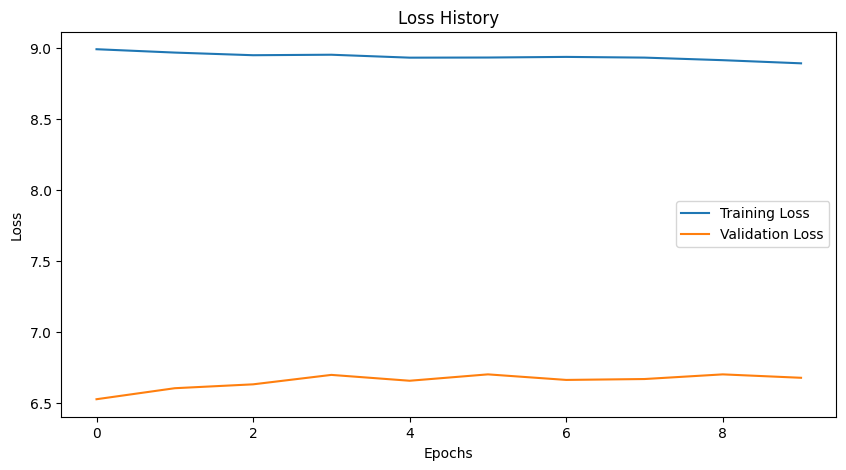

Training model for AUR
Epoch 1/10
2/2 [==============================] - 5s 887ms/step - loss: 33.3805 - val_loss: 25.0809
Epoch 2/10
2/2 [==============================] - 0s 50ms/step - loss: 33.3161 - val_loss: 25.1553
Epoch 3/10
2/2 [==============================] - 0s 64ms/step - loss: 33.3157 - val_loss: 25.1331
Epoch 4/10
2/2 [==============================] - 0s 52ms/step - loss: 33.2801 - val_loss: 25.1173
Epoch 5/10
2/2 [==============================] - 0s 55ms/step - loss: 33.2478 - val_loss: 25.1043
Epoch 6/10
2/2 [==============================] - 0s 52ms/step - loss: 33.2028 - val_loss: 25.0860
Epoch 7/10
2/2 [==============================] - 0s 54ms/step - loss: 33.2180 - val_loss: 25.0574
Epoch 8/10
2/2 [==============================] - 0s 52ms/step - loss: 33.1578 - val_loss: 25.0189
Epoch 9/10
2/2 [==============================] - 0s 51ms/step - loss: 33.1789 - val_loss: 24.8719
Epoch 10/10
1/1 [==============================] - 0s 27ms/step - loss: 24.7795
Test 

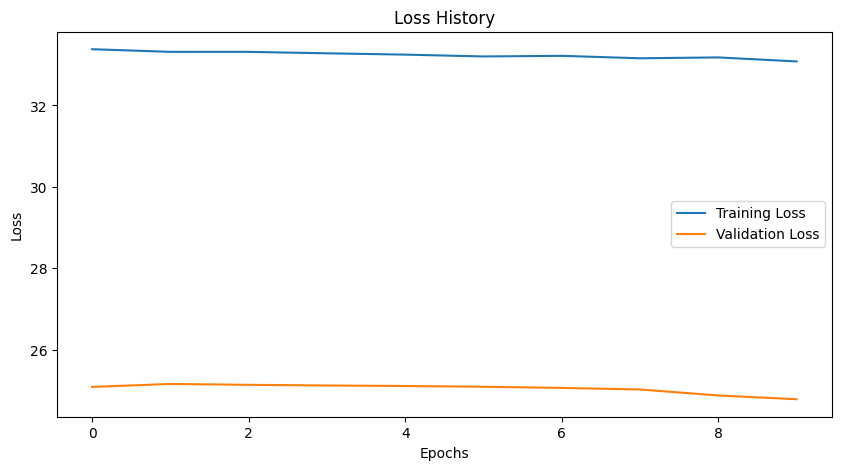

Training model for GOOG
Epoch 1/10
9/9 [==============================] - 5s 215ms/step - loss: 2.9373 - val_loss: 3.0068
Epoch 2/10
9/9 [==============================] - 1s 58ms/step - loss: 2.9183 - val_loss: 3.0351
Epoch 3/10
9/9 [==============================] - 1s 63ms/step - loss: 2.9216 - val_loss: 3.0528
Epoch 4/10
9/9 [==============================] - 0s 37ms/step - loss: 2.9078 - val_loss: 3.0353
Epoch 5/10
9/9 [==============================] - 0s 35ms/step - loss: 2.9093 - val_loss: 3.0307
Epoch 6/10
9/9 [==============================] - 0s 32ms/step - loss: 2.9049 - val_loss: 3.0342
Epoch 7/10
9/9 [==============================] - 0s 30ms/step - loss: 2.9061 - val_loss: 3.0416
Epoch 8/10
9/9 [==============================] - 0s 31ms/step - loss: 2.9083 - val_loss: 3.0519
Epoch 9/10
9/9 [==============================] - 0s 28ms/step - loss: 2.8981 - val_loss: 3.0386
Epoch 10/10
3/3 [==============================] - 0s 8ms/step - loss: 3.0320
Test Loss: 3.03202676773

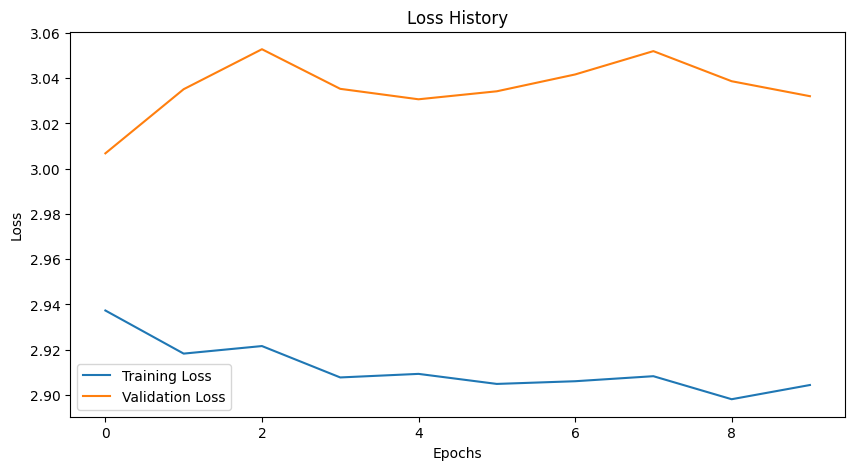

Training model for GM
Epoch 1/10
9/9 [==============================] - 4s 128ms/step - loss: 5.2560 - val_loss: 4.5164
Epoch 2/10
9/9 [==============================] - 0s 29ms/step - loss: 5.2501 - val_loss: 4.4537
Epoch 3/10
9/9 [==============================] - 0s 30ms/step - loss: 5.2381 - val_loss: 4.4849
Epoch 4/10
9/9 [==============================] - 0s 30ms/step - loss: 5.2434 - val_loss: 4.5172
Epoch 5/10
9/9 [==============================] - 0s 28ms/step - loss: 5.2416 - val_loss: 4.5201
Epoch 6/10
9/9 [==============================] - 0s 34ms/step - loss: 5.2455 - val_loss: 4.4879
Epoch 7/10
9/9 [==============================] - 0s 35ms/step - loss: 5.2348 - val_loss: 4.5015
Epoch 8/10
9/9 [==============================] - 0s 48ms/step - loss: 5.2443 - val_loss: 4.4554
Epoch 9/10
9/9 [==============================] - 0s 51ms/step - loss: 5.2278 - val_loss: 4.4814
Epoch 10/10
3/3 [==============================] - 0s 13ms/step - loss: 4.4649
Test Loss: 4.464869976043

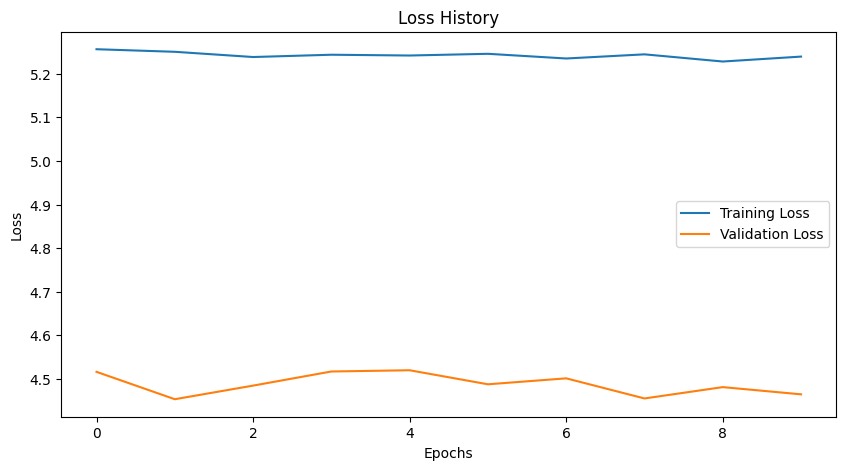

Training model for NVDA
Epoch 1/10
9/9 [==============================] - 5s 132ms/step - loss: 6.7671 - val_loss: 7.6890
Epoch 2/10
9/9 [==============================] - 0s 29ms/step - loss: 6.7369 - val_loss: 7.6723
Epoch 3/10
9/9 [==============================] - 0s 31ms/step - loss: 6.7349 - val_loss: 7.6190
Epoch 4/10
9/9 [==============================] - 0s 28ms/step - loss: 6.7556 - val_loss: 7.5697
Epoch 5/10
9/9 [==============================] - 0s 27ms/step - loss: 6.7564 - val_loss: 7.6823
Epoch 6/10
9/9 [==============================] - 0s 28ms/step - loss: 6.7516 - val_loss: 7.7160
Epoch 7/10
9/9 [==============================] - 0s 33ms/step - loss: 6.7479 - val_loss: 7.6700
Epoch 8/10
9/9 [==============================] - 0s 27ms/step - loss: 6.7328 - val_loss: 7.6286
Epoch 9/10
9/9 [==============================] - 0s 29ms/step - loss: 6.7297 - val_loss: 7.6449
Epoch 10/10
3/3 [==============================] - 0s 9ms/step - loss: 7.6374
Test Loss: 7.63739109039

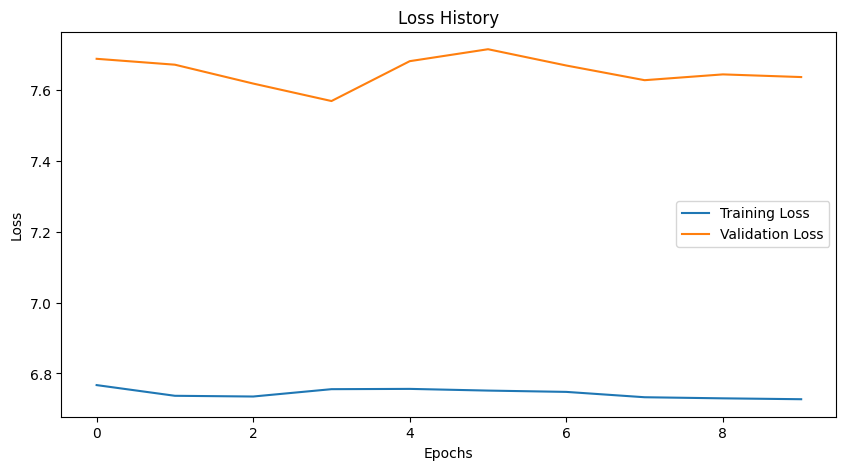

Training model for APTV
Epoch 1/10
9/9 [==============================] - 5s 127ms/step - loss: 5.8234 - val_loss: 3.5184
Epoch 2/10
9/9 [==============================] - 0s 28ms/step - loss: 5.7984 - val_loss: 3.5049
Epoch 3/10
9/9 [==============================] - 0s 29ms/step - loss: 5.7898 - val_loss: 3.4997
Epoch 4/10
9/9 [==============================] - 0s 31ms/step - loss: 5.7905 - val_loss: 3.5046
Epoch 5/10
9/9 [==============================] - 0s 30ms/step - loss: 5.7831 - val_loss: 3.5082
Epoch 6/10
9/9 [==============================] - 0s 30ms/step - loss: 5.7816 - val_loss: 3.5287
Epoch 7/10
9/9 [==============================] - 0s 29ms/step - loss: 5.7811 - val_loss: 3.5369
Epoch 8/10
9/9 [==============================] - 0s 29ms/step - loss: 5.7569 - val_loss: 3.5439
Epoch 9/10
9/9 [==============================] - 0s 29ms/step - loss: 5.7444 - val_loss: 3.5939
Epoch 10/10
3/3 [==============================] - 0s 9ms/step - loss: 3.6672
Test Loss: 3.66723513603

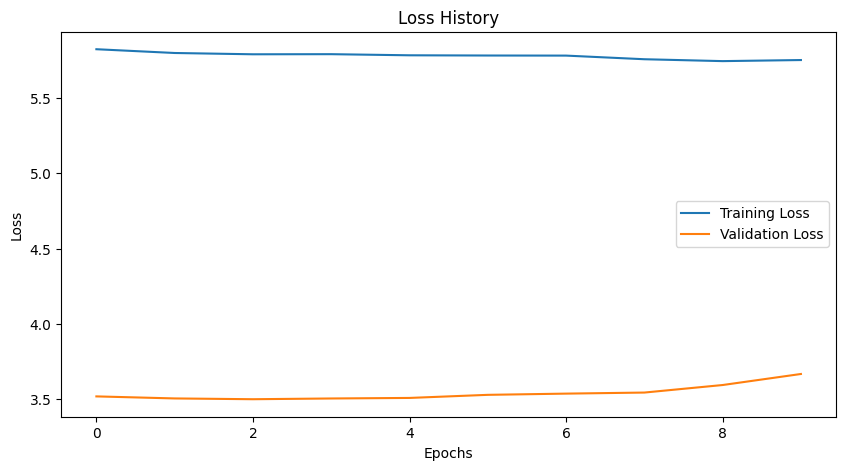

Training model for TSPH
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 112.4155 - val_loss: 175.0088
Epoch 2/10
1/1 [==============================] - 0s 92ms/step - loss: 111.8296 - val_loss: 179.0159
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 111.4657 - val_loss: 183.3148
Epoch 4/10
1/1 [==============================] - 0s 49ms/step - loss: 110.9133 - val_loss: 188.2451
Epoch 5/10
1/1 [==============================] - 0s 50ms/step - loss: 110.1644 - val_loss: 194.1467
Epoch 6/10
1/1 [==============================] - 0s 52ms/step - loss: 109.7461 - val_loss: 201.2550
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 108.7365 - val_loss: 210.1877
Epoch 8/10
1/1 [==============================] - 0s 49ms/step - loss: 107.7670 - val_loss: 221.5781
Epoch 9/10
1/1 [==============================] - 0s 53ms/step - loss: 106.6080 - val_loss: 236.1648
Epoch 10/10
1/1 [==============================] - 0s 25ms/step - los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


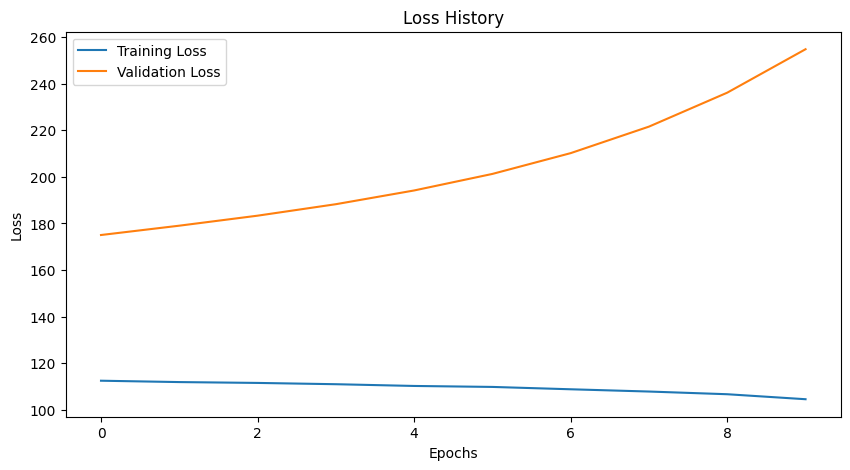

  ticker         mse        r2
0   TSLA    6.678150 -0.033874
1    AUR   24.779505  0.013853
2   GOOG    3.032027 -0.012493
3     GM    4.464870 -0.051762
4   NVDA    7.637391  0.023503
5   APTV    3.667235 -0.051548
6   TSPH  254.823822       NaN


In [ ]:
# Train and evaluate the model for each ticker
results = []
for ticker, data in prepared_data.items():
    print(f"Training model for {ticker}")
    X_train, X_test, y_train, y_test = prepare_data(data, lag_days)
    history, model, mse, r2 = train_lstm(X_train, y_train, X_test, y_test)
    plot_loss_history(history)
    results.append({'ticker': ticker, 'mse': mse, 'r2': r2})

# Display results
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
results_df.to_csv('lagged_lstm_results.csv', index=False)

In [ ]:
files.download('lagged_lstm_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LSTM -  OLD, functions tweaked above.

Analyzing TSLA for same day impact
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.6862 - val_loss: 0.9187
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 2.6825 - val_loss: 0.9170
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 2.6811 - val_loss: 0.9153
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 2.6774 - val_loss: 0.9135
Epoch 5/10
1/1 [==============================] - 0s 52ms/step - loss: 2.6740 - val_loss: 0.9118
Epoch 6/10
1/1 [==============================] - 0s 41ms/step - loss: 2.6686 - val_loss: 0.9102
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 2.6683 - val_loss: 0.9086
Epoch 8/10
1/1 [==============================] - 0s 40ms/step - loss: 2.6668 - val_loss: 0.9071
Epoch 9/10
1/1 [==============================] - 0s 45ms/step - loss: 2.6606 - val_loss: 0.9056
Epoch 10/10
1/1 [==============================] - 0s 33ms/step - loss: 0.9042
Test Loss: 0.90

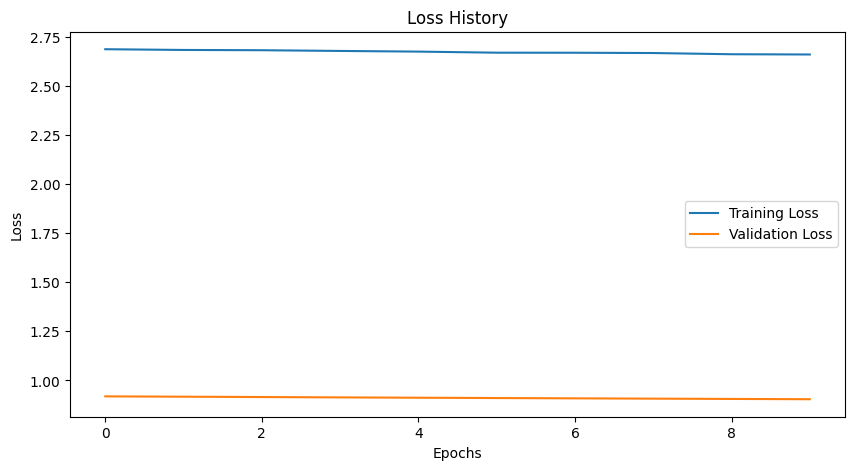

Analyzing TSLA for next day impact
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 2.7728 - val_loss: 5.3782
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 2.7708 - val_loss: 5.3775
Epoch 3/10
1/1 [==============================] - 0s 40ms/step - loss: 2.7635 - val_loss: 5.3768
Epoch 4/10
1/1 [==============================] - 0s 40ms/step - loss: 2.7571 - val_loss: 5.3763
Epoch 5/10
1/1 [==============================] - 0s 43ms/step - loss: 2.7548 - val_loss: 5.3763
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 2.7454 - val_loss: 5.3761
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 2.7422 - val_loss: 5.3764
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 2.7352 - val_loss: 5.3775
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 2.7316 - val_loss: 5.3792
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 5.3814
Test Loss: 5.38

1/1 [==============================] - 1s 767ms/step
Mean Squared Error: 5.381369783413712
R^2 Score: -3.256683344006664


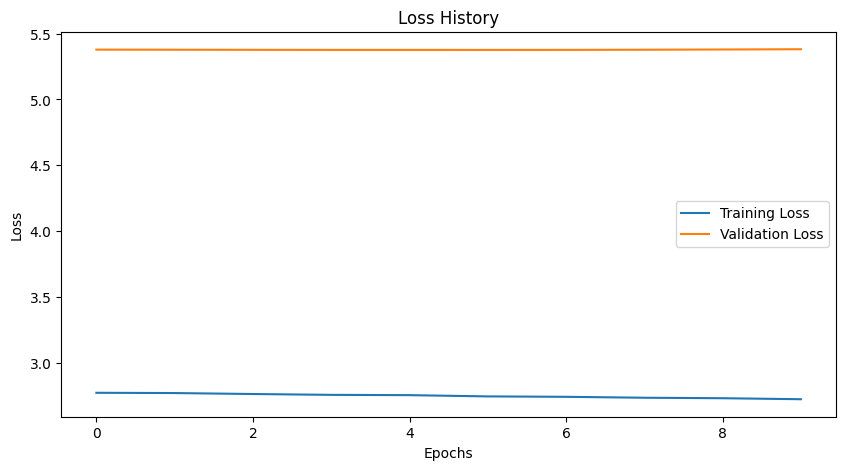

Analyzing TSLA for weekly impact
Epoch 1/10
7/7 [==============================] - 5s 203ms/step - loss: 48.6308 - val_loss: 59.6163
Epoch 2/10
7/7 [==============================] - 0s 21ms/step - loss: 48.6148 - val_loss: 59.5977
Epoch 3/10
7/7 [==============================] - 0s 20ms/step - loss: 48.6011 - val_loss: 59.5937
Epoch 4/10
7/7 [==============================] - 0s 19ms/step - loss: 48.6000 - val_loss: 59.5766
Epoch 5/10
7/7 [==============================] - 0s 23ms/step - loss: 48.5846 - val_loss: 59.5604
Epoch 6/10
7/7 [==============================] - 0s 23ms/step - loss: 48.5749 - val_loss: 59.5463
Epoch 7/10
7/7 [==============================] - 0s 20ms/step - loss: 48.5466 - val_loss: 59.5324
Epoch 8/10
7/7 [==============================] - 0s 22ms/step - loss: 48.5255 - val_loss: 59.5096
Epoch 9/10
7/7 [==============================] - 0s 20ms/step - loss: 48.5259 - val_loss: 59.4903
Epoch 10/10
2/2 [==============================] - 0s 7ms/step - loss: 59.4

2/2 [==============================] - 1s 10ms/step
Mean Squared Error: 59.46927739799304
R^2 Score: -0.004637109906832748


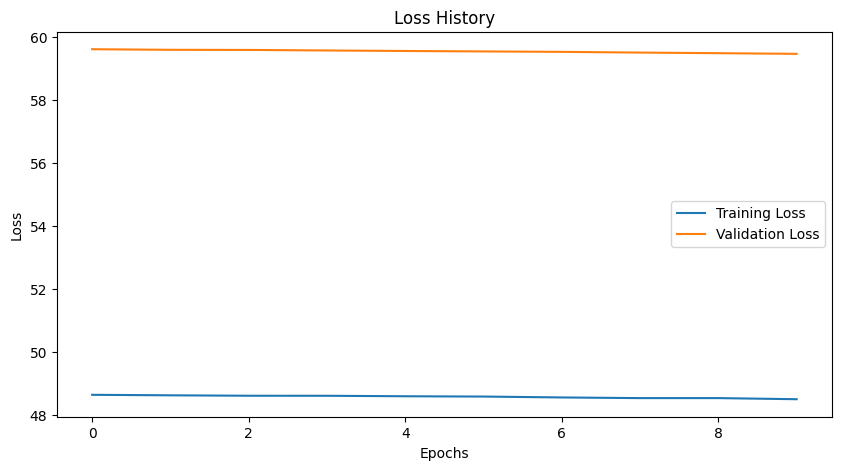

Analyzing AUR for same day impact
Not enough data for AUR same day impact analysis.
Analyzing AUR for next day impact
Not enough data for AUR next day impact analysis.
Analyzing AUR for weekly impact
Epoch 1/10
2/2 [==============================] - 4s 878ms/step - loss: 120.6650 - val_loss: 39.7032
Epoch 2/10
2/2 [==============================] - 0s 39ms/step - loss: 120.5713 - val_loss: 39.6406
Epoch 3/10
2/2 [==============================] - 0s 38ms/step - loss: 120.4982 - val_loss: 39.5808
Epoch 4/10
2/2 [==============================] - 0s 39ms/step - loss: 120.3788 - val_loss: 39.5153
Epoch 5/10
2/2 [==============================] - 0s 37ms/step - loss: 120.2912 - val_loss: 39.4458
Epoch 6/10
2/2 [==============================] - 0s 37ms/step - loss: 120.1750 - val_loss: 39.3704
Epoch 7/10
2/2 [==============================] - 0s 40ms/step - loss: 120.0940 - val_loss: 39.2884
Epoch 8/10
2/2 [==============================] - 0s 36ms/step - loss: 119.9727 - val_loss: 39.2007

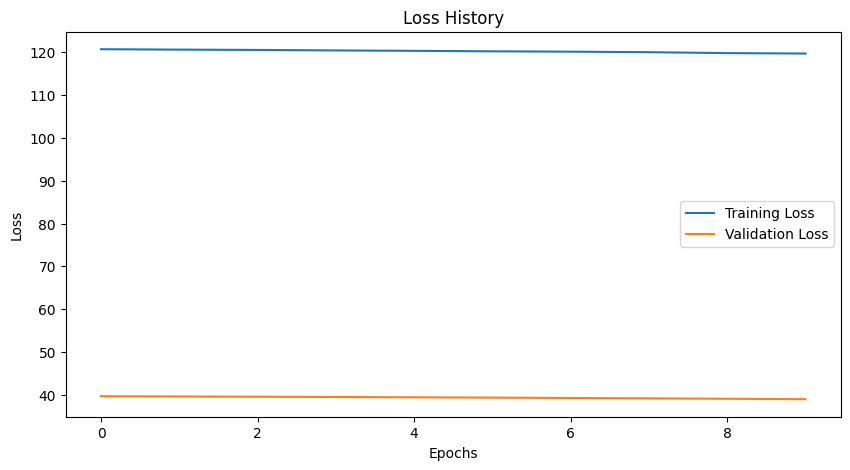

Analyzing GOOG for same day impact
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.7687 - val_loss: 2.9308
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 1.7630 - val_loss: 2.9181
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 1.7571 - val_loss: 2.9052
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 1.7490 - val_loss: 2.8922
Epoch 5/10
1/1 [==============================] - 0s 45ms/step - loss: 1.7443 - val_loss: 2.8791
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 1.7393 - val_loss: 2.8657
Epoch 7/10
1/1 [==============================] - 0s 43ms/step - loss: 1.7302 - val_loss: 2.8520
Epoch 8/10
1/1 [==============================] - 0s 44ms/step - loss: 1.7242 - val_loss: 2.8380
Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 1.7184 - val_loss: 2.8235
Epoch 10/10
1/1 [==============================] - 0s 24ms/step - loss: 2.8087
Test Loss: 2.80

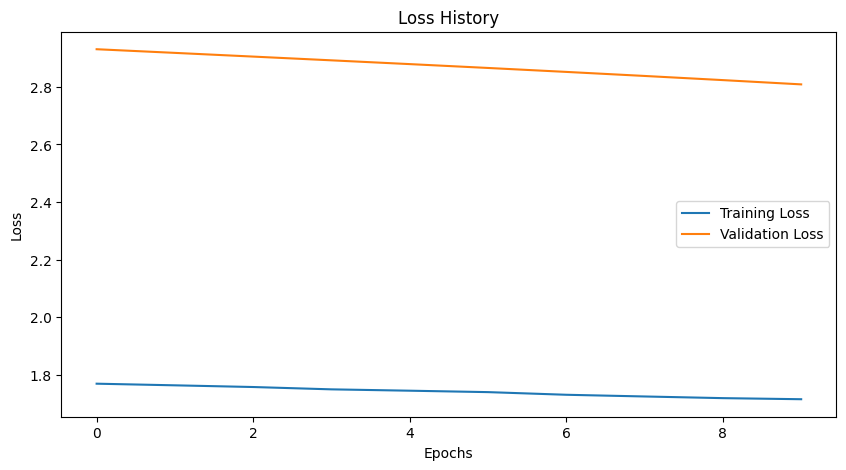

Analyzing GOOG for next day impact
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.4365 - val_loss: 2.2613
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 1.4326 - val_loss: 2.2545
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 1.4283 - val_loss: 2.2475
Epoch 4/10
1/1 [==============================] - 0s 45ms/step - loss: 1.4239 - val_loss: 2.2401
Epoch 5/10
1/1 [==============================] - 0s 73ms/step - loss: 1.4184 - val_loss: 2.2330
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 1.4160 - val_loss: 2.2257
Epoch 7/10
1/1 [==============================] - 0s 76ms/step - loss: 1.4114 - val_loss: 2.2183
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 1.4050 - val_loss: 2.2106
Epoch 9/10
1/1 [==============================] - 0s 55ms/step - loss: 1.4020 - val_loss: 2.2023
Epoch 10/10
1/1 [==============================] - 0s 37ms/step - loss: 2.1939
Test Loss: 2.19

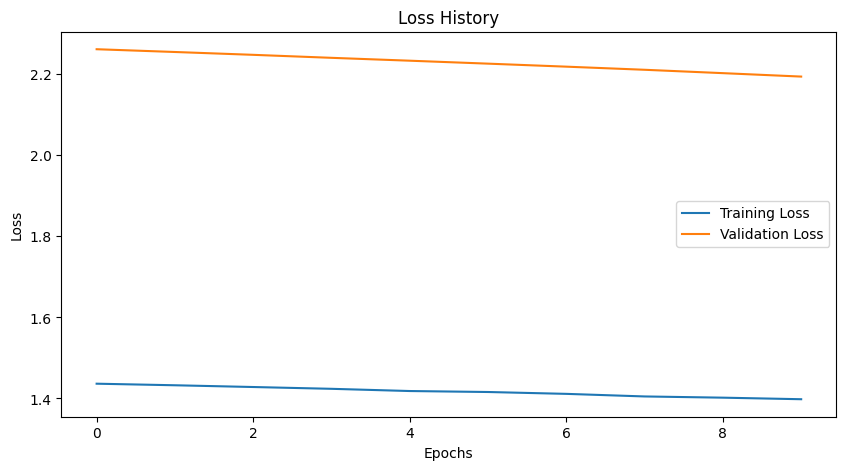

Analyzing GOOG for weekly impact
Epoch 1/10
7/7 [==============================] - 4s 148ms/step - loss: 11.1766 - val_loss: 14.1726
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 11.1709 - val_loss: 14.1783
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 11.1689 - val_loss: 14.1715
Epoch 4/10
7/7 [==============================] - 0s 12ms/step - loss: 11.1671 - val_loss: 14.1626
Epoch 5/10
7/7 [==============================] - 0s 15ms/step - loss: 11.1653 - val_loss: 14.1522
Epoch 6/10
7/7 [==============================] - 0s 14ms/step - loss: 11.1569 - val_loss: 14.1491
Epoch 7/10
7/7 [==============================] - 0s 13ms/step - loss: 11.1547 - val_loss: 14.1397
Epoch 8/10
7/7 [==============================] - 0s 15ms/step - loss: 11.1540 - val_loss: 14.1288
Epoch 9/10
7/7 [==============================] - 0s 15ms/step - loss: 11.1558 - val_loss: 14.1231
Epoch 10/10
2/2 [==============================] - 0s 13ms/step - loss: 14.

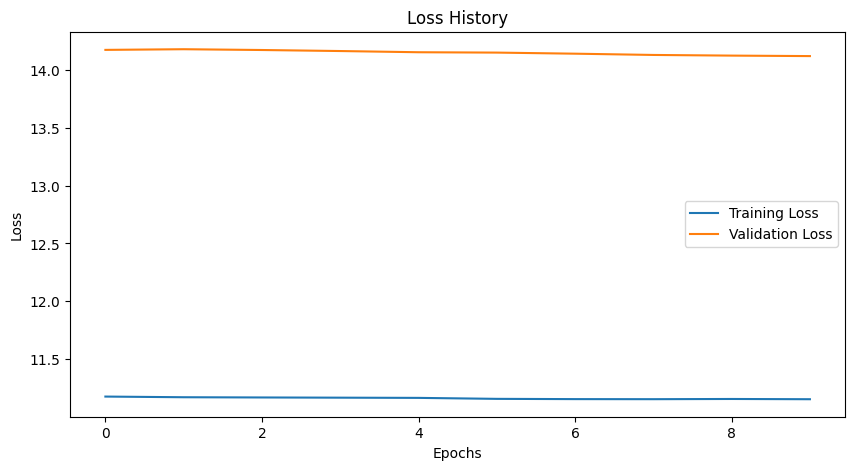

Analyzing GM for same day impact
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 3.8360 - val_loss: 2.4781
Epoch 2/10
1/1 [==============================] - 0s 47ms/step - loss: 3.8267 - val_loss: 2.4725
Epoch 3/10
1/1 [==============================] - 0s 46ms/step - loss: 3.8157 - val_loss: 2.4668
Epoch 4/10
1/1 [==============================] - 0s 50ms/step - loss: 3.8062 - val_loss: 2.4609
Epoch 5/10
1/1 [==============================] - 0s 47ms/step - loss: 3.7978 - val_loss: 2.4549
Epoch 6/10
1/1 [==============================] - 0s 45ms/step - loss: 3.7896 - val_loss: 2.4486
Epoch 7/10
1/1 [==============================] - 0s 46ms/step - loss: 3.7771 - val_loss: 2.4422
Epoch 8/10
1/1 [==============================] - 0s 51ms/step - loss: 3.7769 - val_loss: 2.4359
Epoch 9/10
1/1 [==============================] - 0s 51ms/step - loss: 3.7650 - val_loss: 2.4296
Epoch 10/10
1/1 [==============================] - 0s 26ms/step - loss: 2.4232
Test Loss: 2.4232

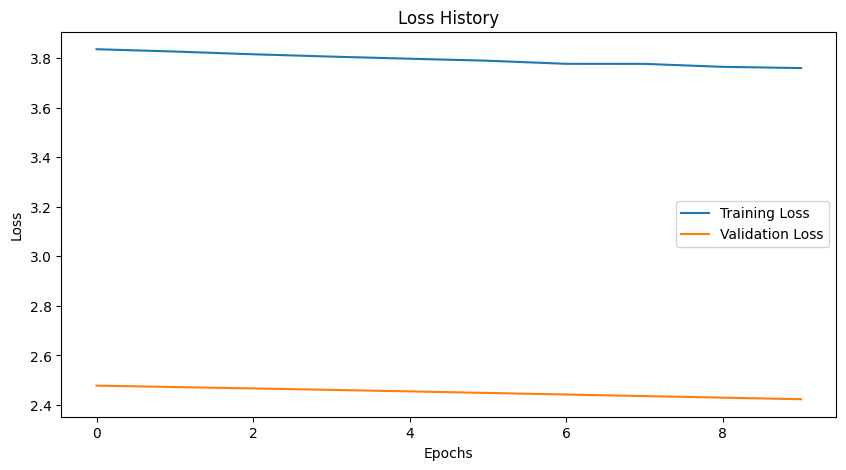

Analyzing GM for next day impact
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 4.6206 - val_loss: 7.1737
Epoch 2/10
1/1 [==============================] - 0s 50ms/step - loss: 4.6178 - val_loss: 7.1897
Epoch 3/10
1/1 [==============================] - 0s 47ms/step - loss: 4.6090 - val_loss: 7.2064
Epoch 4/10
1/1 [==============================] - 0s 50ms/step - loss: 4.6038 - val_loss: 7.2236
Epoch 5/10
1/1 [==============================] - 0s 48ms/step - loss: 4.6003 - val_loss: 7.2413
Epoch 6/10
1/1 [==============================] - 0s 47ms/step - loss: 4.5934 - val_loss: 7.2595
Epoch 7/10
1/1 [==============================] - 0s 51ms/step - loss: 4.5899 - val_loss: 7.2783
Epoch 8/10
1/1 [==============================] - 0s 50ms/step - loss: 4.5838 - val_loss: 7.2979
Epoch 9/10
1/1 [==============================] - 0s 47ms/step - loss: 4.5786 - val_loss: 7.3180
Epoch 10/10
1/1 [==============================] - 0s 25ms/step - loss: 7.3391
Test Loss: 7.3391

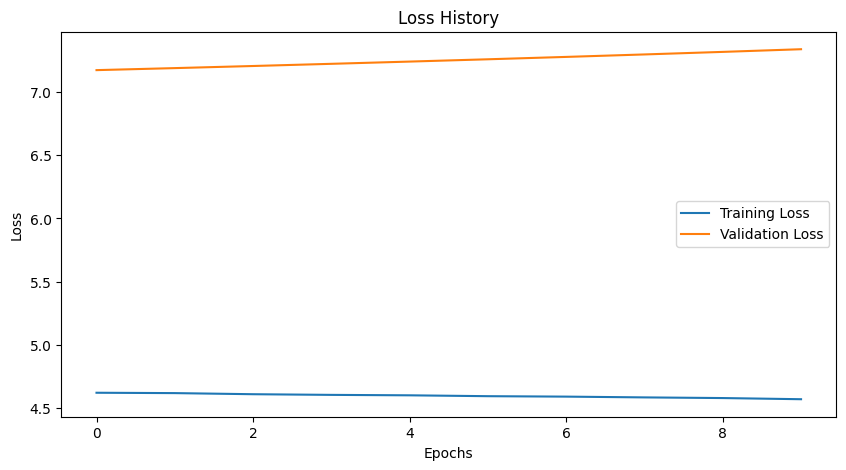

Analyzing GM for weekly impact
Epoch 1/10
7/7 [==============================] - 5s 161ms/step - loss: 24.8647 - val_loss: 21.2964
Epoch 2/10
7/7 [==============================] - 0s 15ms/step - loss: 24.8586 - val_loss: 21.2893
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 24.8559 - val_loss: 21.2925
Epoch 4/10
7/7 [==============================] - 0s 15ms/step - loss: 24.8550 - val_loss: 21.2941
Epoch 5/10
7/7 [==============================] - 0s 15ms/step - loss: 24.8536 - val_loss: 21.2998
Epoch 6/10
7/7 [==============================] - 0s 15ms/step - loss: 24.8576 - val_loss: 21.2995
Epoch 7/10
7/7 [==============================] - 0s 15ms/step - loss: 24.8535 - val_loss: 21.3060
Epoch 8/10
7/7 [==============================] - 0s 18ms/step - loss: 24.8473 - val_loss: 21.3070
Epoch 9/10
7/7 [==============================] - 0s 19ms/step - loss: 24.8513 - val_loss: 21.3124
Epoch 10/10
2/2 [==============================] - 0s 10ms/step - loss: 21.31

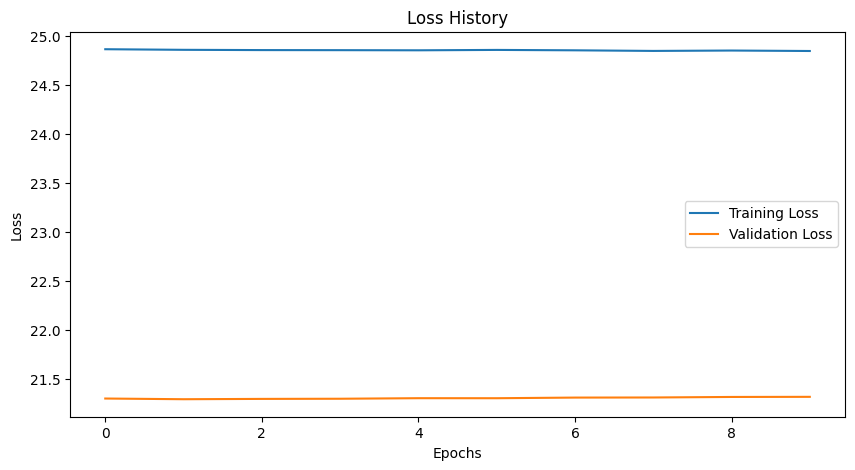

Analyzing NVDA for same day impact
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 2.7162 - val_loss: 14.7595
Epoch 2/10
1/1 [==============================] - 0s 100ms/step - loss: 2.7074 - val_loss: 14.7215
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 2.6966 - val_loss: 14.6832
Epoch 4/10
1/1 [==============================] - 0s 87ms/step - loss: 2.6944 - val_loss: 14.6449
Epoch 5/10
1/1 [==============================] - 0s 74ms/step - loss: 2.6839 - val_loss: 14.6061
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 2.6768 - val_loss: 14.5665
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 2.6700 - val_loss: 14.5260
Epoch 8/10
1/1 [==============================] - 0s 70ms/step - loss: 2.6640 - val_loss: 14.4849
Epoch 9/10
1/1 [==============================] - 0s 59ms/step - loss: 2.6547 - val_loss: 14.4424
Epoch 10/10
1/1 [==============================] - 0s 24ms/step - loss: 14.3983
Test

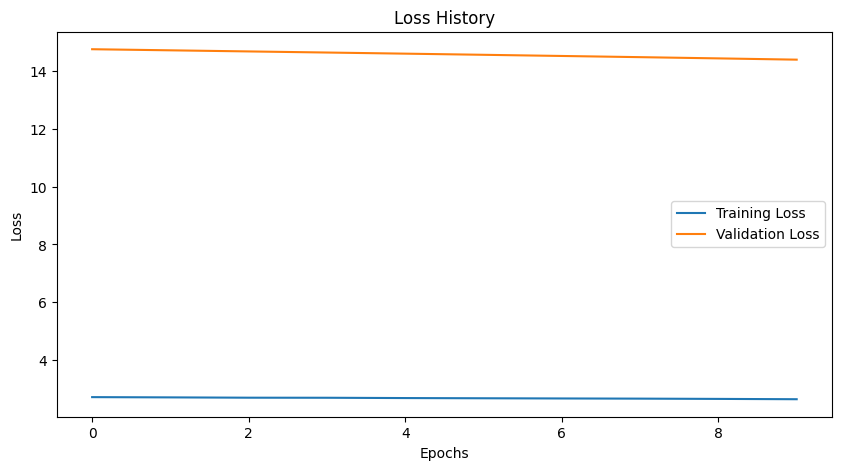

Analyzing NVDA for next day impact
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 4.5761 - val_loss: 6.2991
Epoch 2/10
1/1 [==============================] - 0s 49ms/step - loss: 4.5717 - val_loss: 6.2894
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 4.5553 - val_loss: 6.2790
Epoch 4/10
1/1 [==============================] - 0s 51ms/step - loss: 4.5504 - val_loss: 6.2683
Epoch 5/10
1/1 [==============================] - 0s 49ms/step - loss: 4.5422 - val_loss: 6.2578
Epoch 6/10
1/1 [==============================] - 0s 49ms/step - loss: 4.5295 - val_loss: 6.2469
Epoch 7/10
1/1 [==============================] - 0s 50ms/step - loss: 4.5245 - val_loss: 6.2360
Epoch 8/10
1/1 [==============================] - 0s 47ms/step - loss: 4.5190 - val_loss: 6.2248
Epoch 9/10
1/1 [==============================] - 0s 46ms/step - loss: 4.5096 - val_loss: 6.2136
Epoch 10/10
1/1 [==============================] - 0s 26ms/step - loss: 6.2024
Test Loss: 6.20

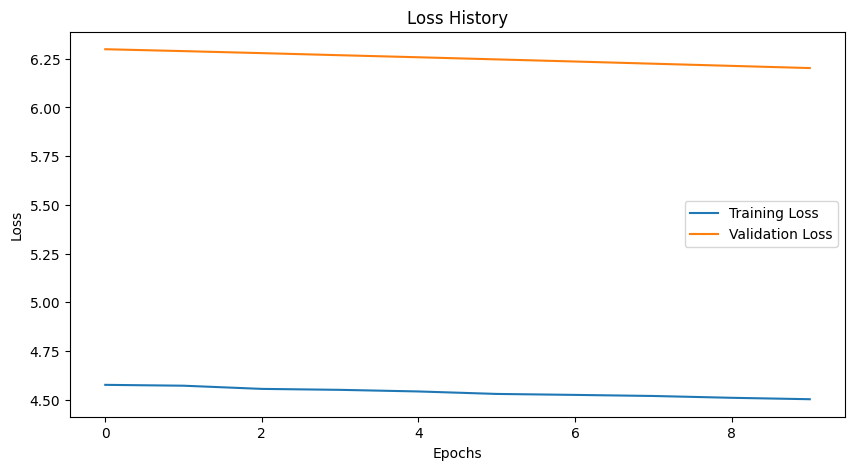

Analyzing NVDA for weekly impact
Epoch 1/10
7/7 [==============================] - 6s 164ms/step - loss: 38.3887 - val_loss: 30.1537
Epoch 2/10
7/7 [==============================] - 0s 15ms/step - loss: 38.3240 - val_loss: 30.1030
Epoch 3/10
7/7 [==============================] - 0s 18ms/step - loss: 38.2711 - val_loss: 30.0602
Epoch 4/10
7/7 [==============================] - 0s 17ms/step - loss: 38.2260 - val_loss: 30.0185
Epoch 5/10
7/7 [==============================] - 0s 18ms/step - loss: 38.1536 - val_loss: 29.9647
Epoch 6/10
7/7 [==============================] - 0s 14ms/step - loss: 38.0915 - val_loss: 29.8973
Epoch 7/10
7/7 [==============================] - 0s 13ms/step - loss: 38.0298 - val_loss: 29.8080
Epoch 8/10
7/7 [==============================] - 0s 15ms/step - loss: 37.9556 - val_loss: 29.7440
Epoch 9/10
7/7 [==============================] - 0s 16ms/step - loss: 37.8311 - val_loss: 29.7053
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 29.6

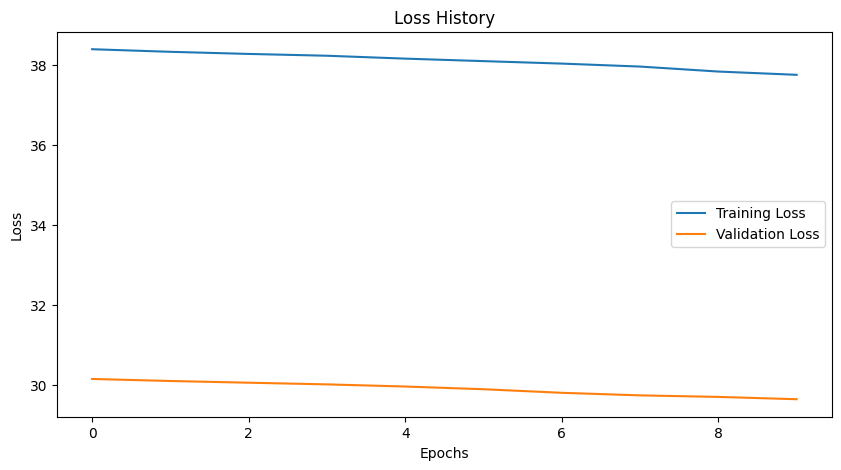

Analyzing APTV for same day impact
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 5.3290 - val_loss: 4.3933
Epoch 2/10
1/1 [==============================] - 0s 121ms/step - loss: 5.3257 - val_loss: 4.3910
Epoch 3/10
1/1 [==============================] - 0s 89ms/step - loss: 5.3237 - val_loss: 4.3884
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 5.3207 - val_loss: 4.3859
Epoch 5/10
1/1 [==============================] - 0s 92ms/step - loss: 5.3191 - val_loss: 4.3836
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 5.3179 - val_loss: 4.3811
Epoch 7/10
1/1 [==============================] - 0s 94ms/step - loss: 5.3158 - val_loss: 4.3787
Epoch 8/10
1/1 [==============================] - 0s 90ms/step - loss: 5.3110 - val_loss: 4.3757
Epoch 9/10
1/1 [==============================] - 0s 98ms/step - loss: 5.3073 - val_loss: 4.3729
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 4.3698
Test Loss: 4.3

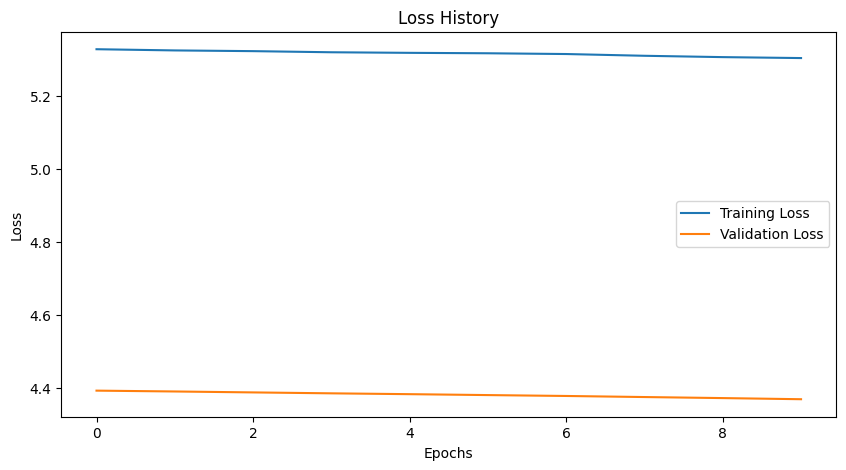

Analyzing APTV for next day impact
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.8861 - val_loss: 3.9306
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 1.8847 - val_loss: 3.9225
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 1.8845 - val_loss: 3.9146
Epoch 4/10
1/1 [==============================] - 0s 51ms/step - loss: 1.8814 - val_loss: 3.9078
Epoch 5/10
1/1 [==============================] - 0s 48ms/step - loss: 1.8795 - val_loss: 3.9006
Epoch 6/10
1/1 [==============================] - 0s 49ms/step - loss: 1.8810 - val_loss: 3.8936
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 1.8773 - val_loss: 3.8860
Epoch 8/10
1/1 [==============================] - 0s 47ms/step - loss: 1.8769 - val_loss: 3.8781
Epoch 9/10
1/1 [==============================] - 0s 51ms/step - loss: 1.8753 - val_loss: 3.8700
Epoch 10/10
1/1 [==============================] - 0s 28ms/step - loss: 3.8616
Test Loss: 3.86

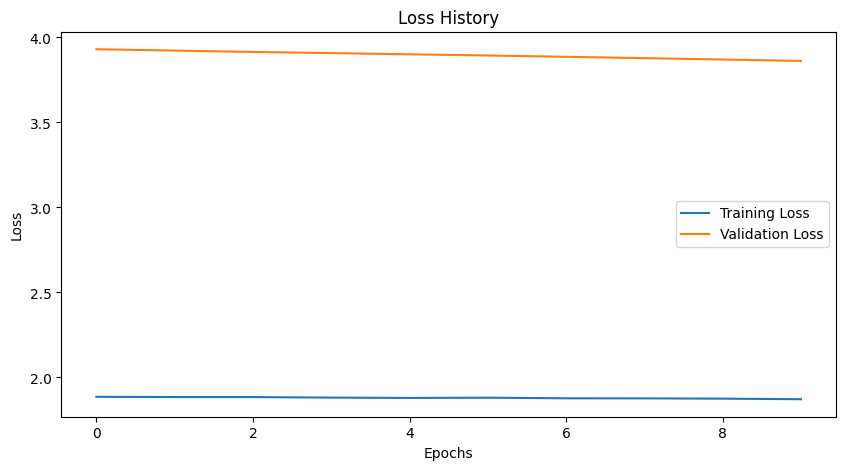

Analyzing APTV for weekly impact
Epoch 1/10
7/7 [==============================] - 7s 161ms/step - loss: 29.4781 - val_loss: 19.5258
Epoch 2/10
7/7 [==============================] - 0s 17ms/step - loss: 29.4716 - val_loss: 19.5277
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 29.4773 - val_loss: 19.5315
Epoch 4/10
7/7 [==============================] - 0s 18ms/step - loss: 29.4747 - val_loss: 19.5295
Epoch 5/10
7/7 [==============================] - 0s 16ms/step - loss: 29.4719 - val_loss: 19.5294
Epoch 6/10
7/7 [==============================] - 0s 18ms/step - loss: 29.4757 - val_loss: 19.5389
Epoch 7/10
7/7 [==============================] - 0s 16ms/step - loss: 29.4728 - val_loss: 19.5423
Epoch 8/10
7/7 [==============================] - 0s 17ms/step - loss: 29.4751 - val_loss: 19.5445
Epoch 9/10
7/7 [==============================] - 0s 15ms/step - loss: 29.4776 - val_loss: 19.5410
Epoch 10/10
2/2 [==============================] - 0s 9ms/step - loss: 19.5

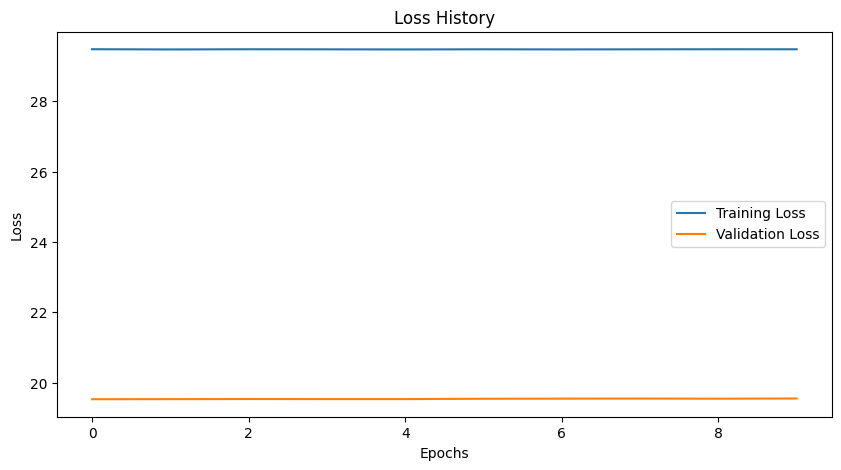

Analyzing TSPH for same day impact
Not enough data for TSPH same day impact analysis.
Analyzing TSPH for next day impact
Not enough data for TSPH next day impact analysis.
Analyzing TSPH for weekly impact
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 833.7152 - val_loss: 159.4219
Epoch 2/10
1/1 [==============================] - 0s 91ms/step - loss: 833.6498 - val_loss: 159.4725
Epoch 3/10
1/1 [==============================] - 0s 67ms/step - loss: 833.6400 - val_loss: 159.5254
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 833.5821 - val_loss: 159.5811
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 833.5023 - val_loss: 159.6331
Epoch 6/10
1/1 [==============================] - 0s 92ms/step - loss: 833.4062 - val_loss: 159.6853
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 833.4112 - val_loss: 159.7367
Epoch 8/10
1/1 [==============================] - 0s 86ms/step - loss: 833.3719 - val_loss

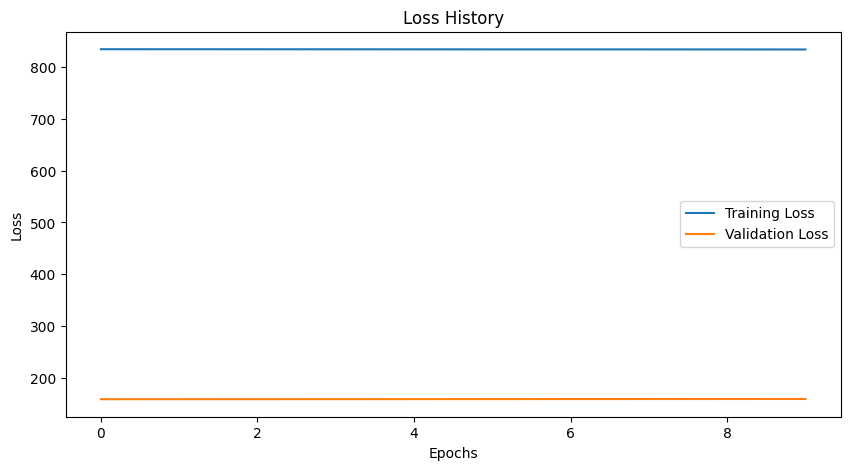

   ticker shift_days         mse        r2
0    TSLA          0    0.904176 -0.073068
1    TSLA          1    5.381370 -3.256683
2    TSLA     weekly   59.469277 -0.004637
3     AUR     weekly   38.998601  0.010772
4    GOOG          0    2.808688 -0.679575
5    GOOG          1    2.193855 -0.200059
6    GOOG     weekly   14.118953 -0.011923
7      GM          0    2.423245 -0.324621
8      GM          1    7.339129 -0.813074
9      GM     weekly   21.313594 -0.024720
10   NVDA          0   14.398336 -0.060567
11   NVDA          1    6.202351 -0.032551
12   NVDA     weekly   29.647777 -0.018149
13   APTV          0    4.369776 -0.951300
14   APTV          1    3.861646 -5.950820
15   APTV     weekly   19.546729 -0.008653
16   TSPH     weekly  159.891325 -1.729009


In [ ]:
# Analyze the impact for each stock and each timeframe
results = []
for ticker in tickers:
    stock_data = fetch_stock_data(ticker, begin_date, end_date)
    merged_df = merge_data(sentiment_df_2016, stock_data)

    # Same day
    print(f"Analyzing {ticker} for same day impact")
    X_train, X_test, y_train, y_test = prepare_data(merged_df, 0)
    if X_train is not None:
        history, model, mse, r2 = train_lstm(X_train, y_train, X_test, y_test)
        plot_loss_history(history)
        results.append({'ticker': ticker, 'shift_days': 0, 'mse': mse, 'r2': r2})
    else:
        print(f"Not enough data for {ticker} same day impact analysis.")

    # Next day
    print(f"Analyzing {ticker} for next day impact")
    X_train, X_test, y_train, y_test = prepare_data(merged_df, 1)
    if X_train is not None:
        history, model, mse, r2 = train_lstm(X_train, y_train, X_test, y_test)
        plot_loss_history(history)
        results.append({'ticker': ticker, 'shift_days': 1, 'mse': mse, 'r2': r2})
    else:
        print(f"Not enough data for {ticker} next day impact analysis.")

    # Weekly aggregation
    print(f"Analyzing {ticker} for weekly impact")
    weekly_merged_df = aggregate_weekly(sentiment_df_2016, stock_data)
    if not weekly_merged_df.empty:
        features = weekly_merged_df[['sentiment']].values
        target = weekly_merged_df['pct_change'].values
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        history, model, mse, r2 = train_lstm(X_train, y_train, X_test, y_test)
        plot_loss_history(history)
        results.append({'ticker': ticker, 'shift_days': 'weekly', 'mse': mse, 'r2': r2})
    else:
        print(f"Not enough data for {ticker} weekly impact analysis.")

# Display results
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
results_df.to_csv('lstm_results.csv', index=False)


In [ ]:
# Download the CSV file
files.download('lstm_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train and evaluate Random Forest
def train_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=777)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    return model, mse, r2

In [ ]:
results = []
for ticker in tickers:
    stock_data = fetch_stock_data(ticker, begin_date, end_date)
    merged_df = merge_data(sentiment_df_2016, stock_data)

    # Same day
    print(f"Analyzing {ticker} for same day impact")
    X_train, X_test, y_train, y_test = prepare_data(merged_df, 0)
    if X_train is not None:
        model, mse, r2 = train_random_forest(X_train.reshape(X_train.shape[0], -1), y_train, X_test.reshape(X_test.shape[0], -1), y_test)
        results.append({'ticker': ticker, 'shift_days': 0, 'mse': mse, 'r2': r2})
    else:
        print(f"Not enough data for {ticker} same day impact analysis.")

    # Next day
    print(f"Analyzing {ticker} for next day impact")
    X_train, X_test, y_train, y_test = prepare_data(merged_df, 1)
    if X_train is not None:
        model, mse, r2 = train_random_forest(X_train.reshape(X_train.shape[0], -1), y_train, X_test.reshape(X_test.shape[0], -1), y_test)
        results.append({'ticker': ticker, 'shift_days': 1, 'mse': mse, 'r2': r2})
    else:
        print(f"Not enough data for {ticker} next day impact analysis.")

    # Weekly aggregation
    print(f"Analyzing {ticker} for weekly impact")
    weekly_merged_df = aggregate_weekly(sentiment_df_2016, stock_data)
    if not weekly_merged_df.empty:
        features = weekly_merged_df[['sentiment']].values
        target = weekly_merged_df['pct_change'].values
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model, mse, r2 = train_random_forest(X_train, y_train, X_test, y_test)
        results.append({'ticker': ticker, 'shift_days': 'weekly', 'mse': mse, 'r2': r2})
    else:
        print(f"Not enough data for {ticker} weekly impact analysis.")

# Display results
results_df_rf = pd.DataFrame(results)
print(results_df_rf)

Analyzing TSLA for same day impact
Mean Squared Error: 0.8713816257742977
R^2 Score: -0.03414871543312237
Analyzing TSLA for next day impact
Mean Squared Error: 5.434483810921303
R^2 Score: -3.2986967356381998
Analyzing TSLA for weekly impact
Mean Squared Error: 62.87055222327395
R^2 Score: -0.06209613850071971
Analyzing AUR for same day impact
Not enough data for AUR same day impact analysis.
Analyzing AUR for next day impact
Not enough data for AUR next day impact analysis.
Analyzing AUR for weekly impact
Mean Squared Error: 27.99586458109276
R^2 Score: 0.28986473869619767
Analyzing GOOG for same day impact
Mean Squared Error: 2.0964804535498844
R^2 Score: -0.2536803652803339
Analyzing GOOG for next day impact
Mean Squared Error: 1.7891699524320623
R^2 Score: 0.02130726353169432
Analyzing GOOG for weekly impact
Mean Squared Error: 14.382935270306866
R^2 Score: -0.030842661430387164
Analyzing GM for same day impact
Mean Squared Error: 2.458828846220188
R^2 Score: -0.34407245651277085


In [ ]:
results_df_rf.to_csv('random_forest_results.csv', index=False)


In [ ]:
files.download('random_forest_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>